# Notebook to regrid datasets

https://xesmf.readthedocs.io/en/latest/notebooks/Dataset.html

Datasets:
- ROMS NorthSea 1/4° output 1950 - 1999 in spherical coordinates
- AVISO altimetry 1/4° data in Cartesian coordinates (https://resources.marine.copernicus.eu/product-detail/SEALEVEL_GLO_PHY_L4_MY_008_047/INFORMATION)
- ORA20C ensemble member-1 1.0° in Cartesian coordinates



In [32]:
import numpy as np
import xesmf as xe
import xarray as xr


In [33]:
# Import datasets
roms_output_northsea4 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/northsea4/1950_2008_1d/NorthSea4_his.nc')
ora20c_rean = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ORA20C/opa1_prepared.nc')
aviso_altimetry4 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/CMEMS altimetry/l4_duacs_0.25deg/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1659969934244.nc')
cnes_mdt = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/CNES MDT/dataset-mdt-cnes-cls18-global_1660042875042.nc')
roms_output_tim_northsea8 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/Tim/ROMS_output_tim.nc')

### Some data processing

In [34]:
# Remove not-full years
roms_output_northsea4 = roms_output_northsea4.where(roms_output_northsea4.ocean_time.dt.year < 2009, drop = True) # 11 months missing 2009

# Rename coordinates to 'lat' and 'lon'
aviso_altimetry4 = aviso_altimetry4.rename({'latitude':'lat', 'longitude':'lon'})
cnes_mdt = cnes_mdt.rename({'latitude':'lat', 'longitude':'lon'})


# Drop variables
ora20c_rean = ora20c_rean.drop(['so', 'thetao', 'uo', 'vo', 'depth'])

# Sort coordinates in increasing order
aviso_altimetry4 = aviso_altimetry4.sortby(['lat', 'lon'])
ora20c_rean = ora20c_rean.sortby(['lat', 'lon'])

# Transpose dimensions
ora20c_rean = ora20c_rean.transpose('time', 'lat', 'lon')
cnes_mdt = cnes_mdt.transpose('time', 'lat', 'lon')




In [35]:
# Make arrays C_CONTIGUOUS
roms_output_northsea4['zeta'] = roms_output_northsea4['zeta'].astype(dtype = 'float32', order = 'C')
ora20c_rean['zos'] = ora20c_rean['zos'].astype(dtype = 'float32', order = 'C')
aviso_altimetry4['adt'] = aviso_altimetry4['adt'].astype(dtype = 'float64', order = 'C')
cnes_mdt['mdt'] = cnes_mdt['mdt'].astype(dtype = 'float64', order = 'C')





In [36]:
# Make extent of the ora reanalysis data similar to ROMS
ora20c_rean = ora20c_rean.where((ora20c_rean.lat >= 36) & (ora20c_rean.lat <= 62) & (ora20c_rean.lon >= -20) & (ora20c_rean.lon <= 10), drop = True)
cnes_mdt = cnes_mdt.where((cnes_mdt.lat >= 36) & (cnes_mdt.lat <= 62) & (cnes_mdt.lon >= -20) & (cnes_mdt.lon <= 10), drop = True)




## Plot the reference grid: altimetry

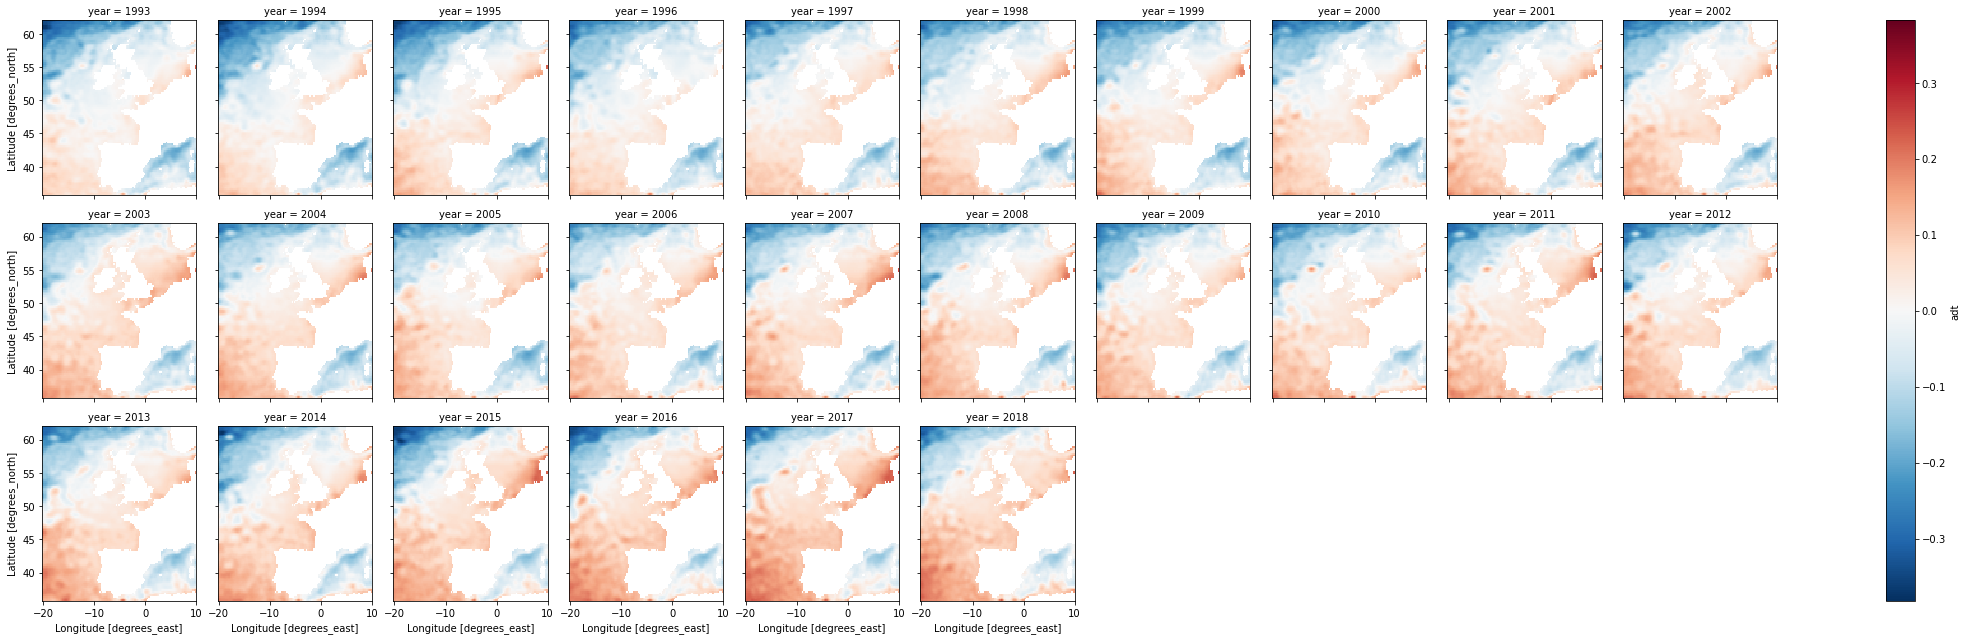

In [37]:
aviso_altimetry4_an = aviso_altimetry4.groupby('time.year').mean()

aviso_altimetry4_an.adt.plot(col = 'year', col_wrap = 10)

## Regrid the ORA-20C reanalysis data

In [38]:
# Add mask
ora20c_rean['mask'] = xr.where(~np.isnan(ora20c_rean.zos.isel(time=0)), 1, 0)
aviso_altimetry4['mask'] = xr.where(~np.isnan(aviso_altimetry4.adt.isel(time=0)), 1, 0)


# Build regridder
regridder = xe.Regridder(ora20c_rean, aviso_altimetry4, "bilinear")


# Apply to data
ora20c_rean4 = regridder(ora20c_rean)

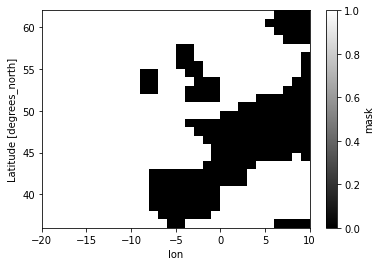

In [39]:
ora20c_rean.mask.plot(cmap="binary_r")

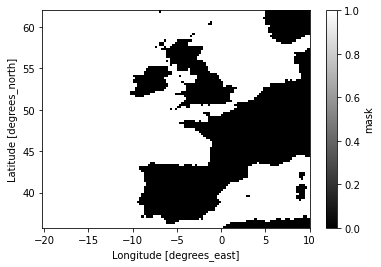

In [40]:
aviso_altimetry4.mask.plot(cmap="binary_r")


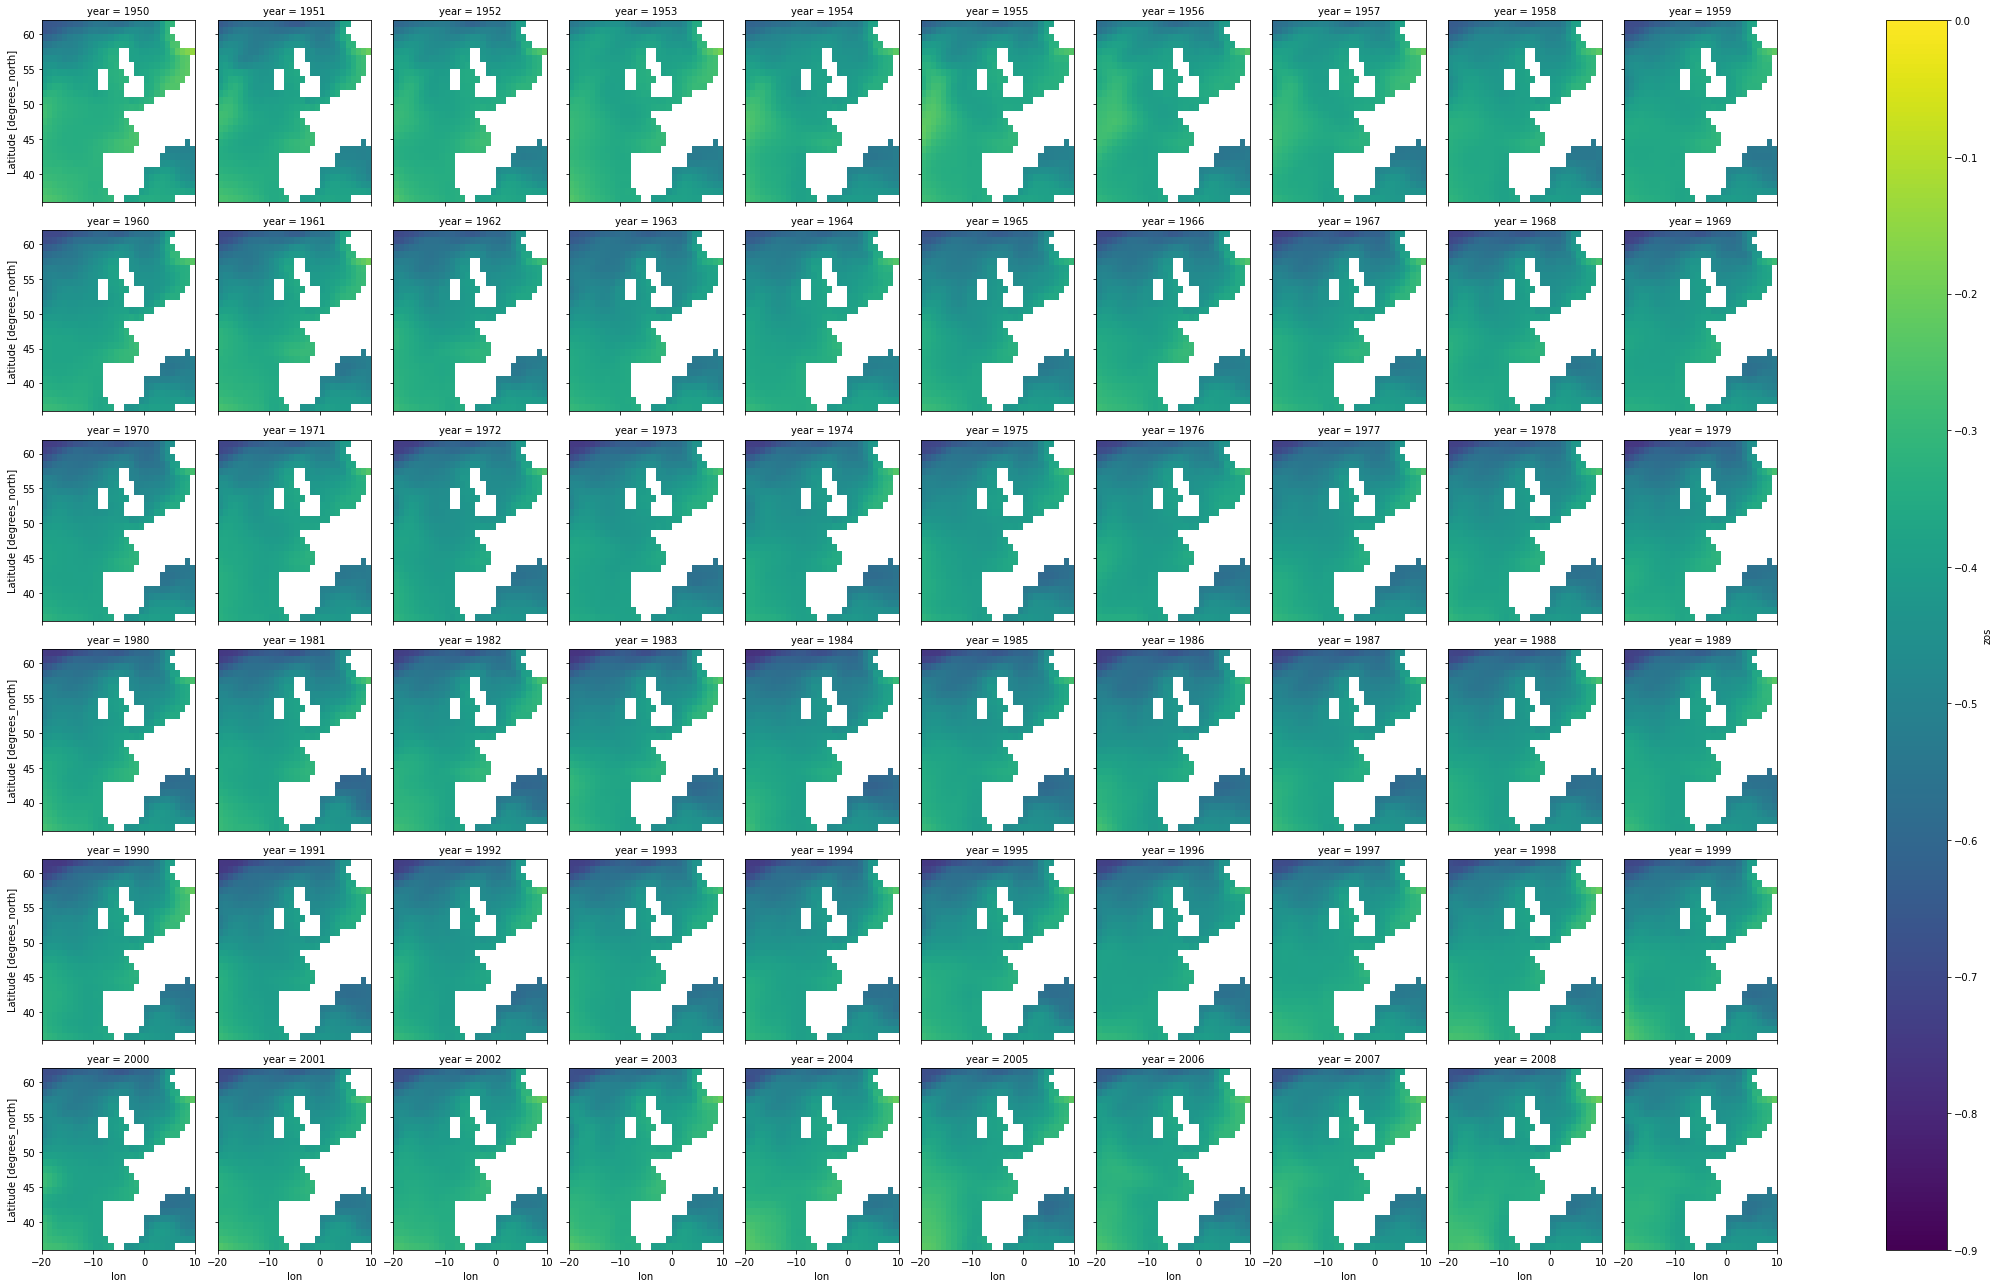

In [41]:
ora20c_rean_an = ora20c_rean.groupby('time.year').mean()

ora20c_rean_an.where(ora20c_rean_an.year >= 1950, drop = True).zos.plot(col = 'year', col_wrap = 10, vmin = -0.9, vmax = 0 )

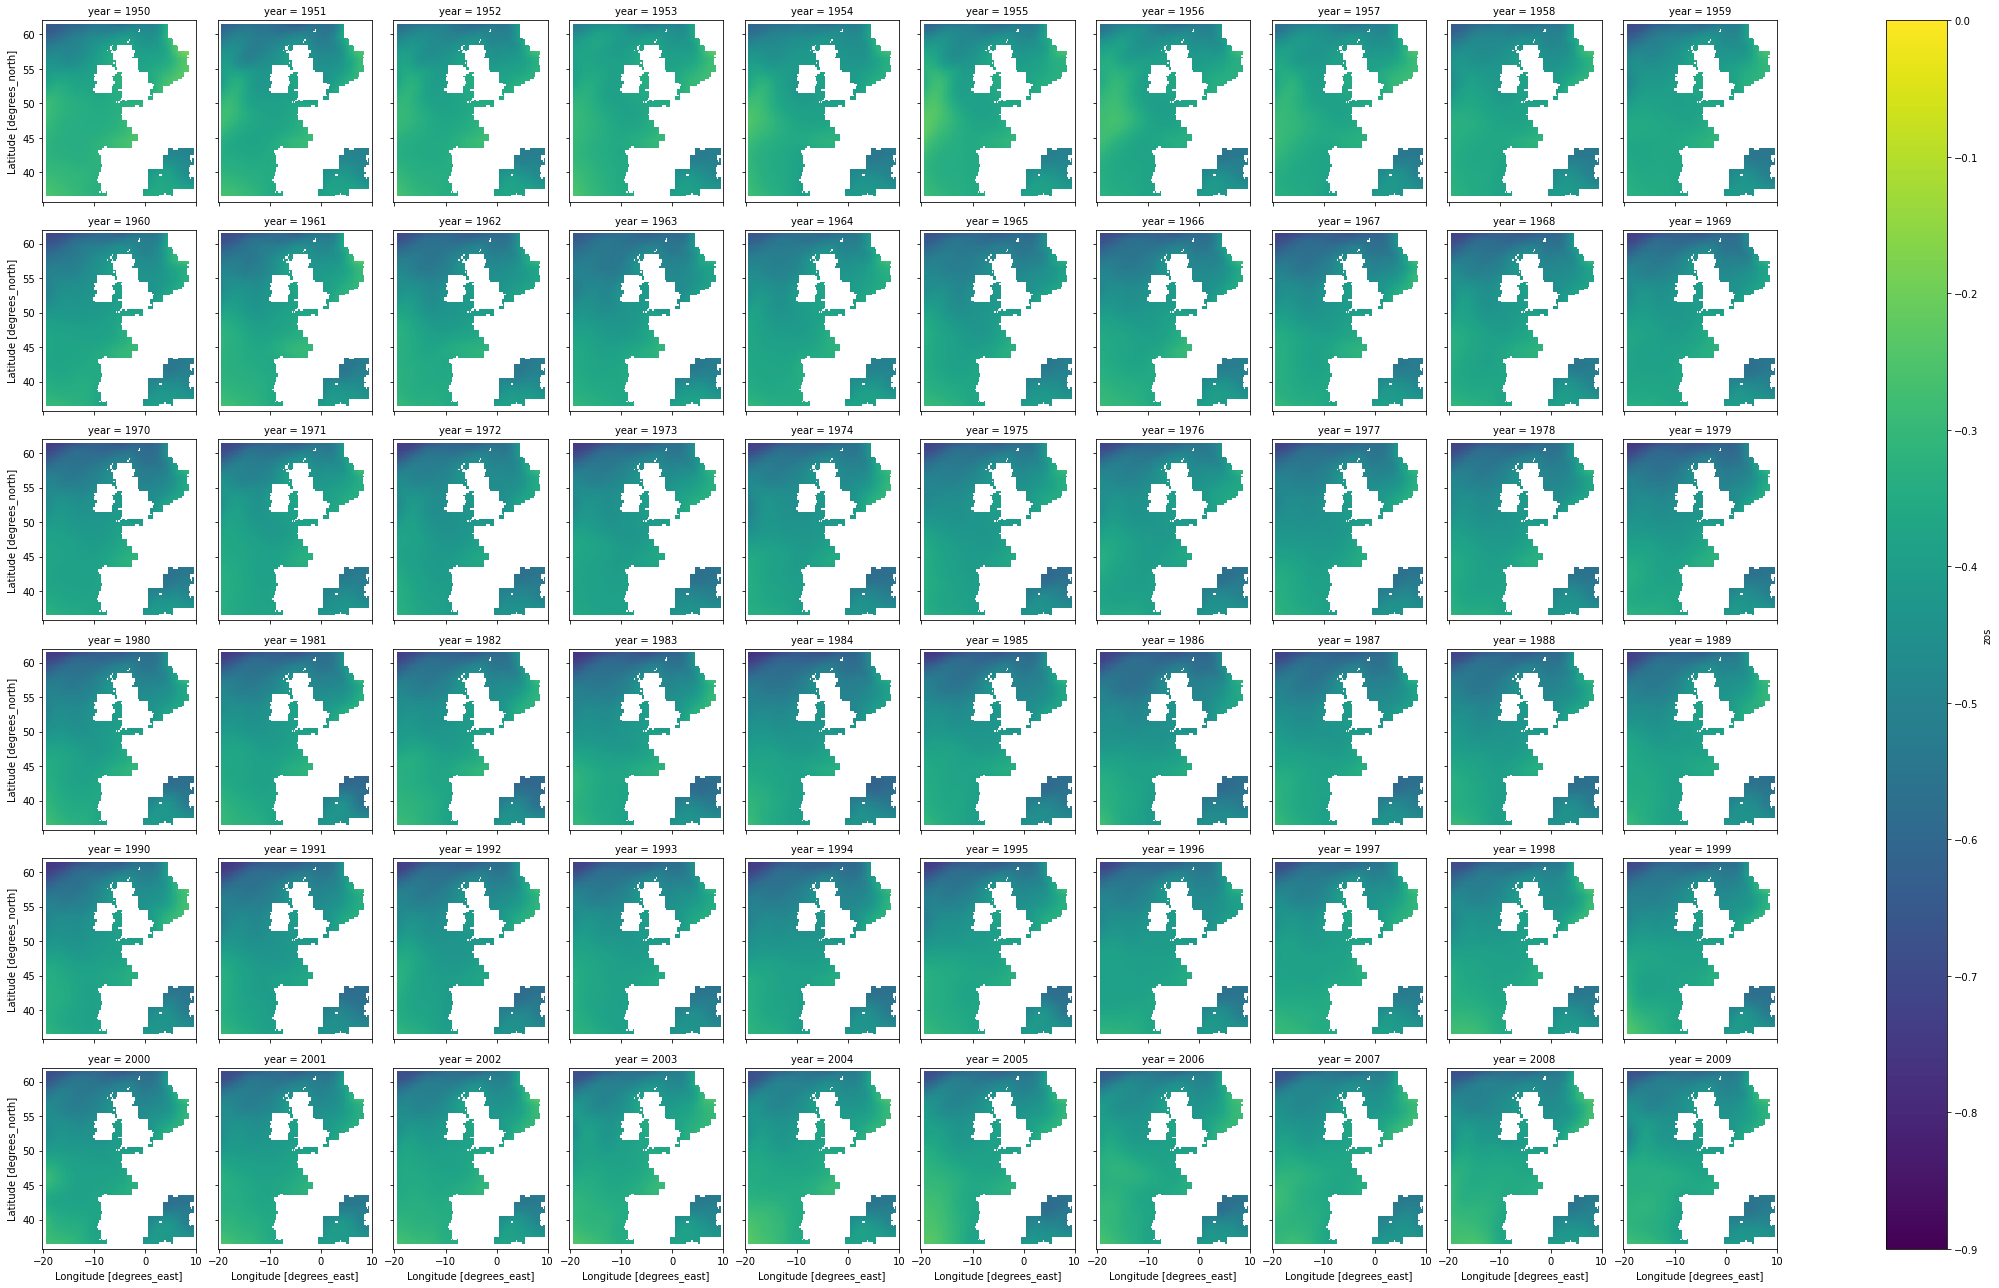

In [42]:
ora20c_rean4_an = ora20c_rean4.groupby('time.year').mean()

ora20c_rean4_an.where(ora20c_rean4_an.year >= 1950, drop = True).zos.plot(col = 'year', col_wrap = 10, vmin = -0.9, vmax = 0)

In [43]:
# Save the dataset
ora20c_rean4.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/regridded/to aviso4/ora20c_opa1.nc')

## Regrid the MDT data

In [44]:
# Add mask
cnes_mdt['mask'] = xr.where(~np.isnan(cnes_mdt.mdt.isel(time=0)), 1, 0)


# Build regridder
regridder = xe.Regridder(cnes_mdt, aviso_altimetry4, "bilinear")


# Apply to data
cnes_mdt4 = regridder(cnes_mdt)

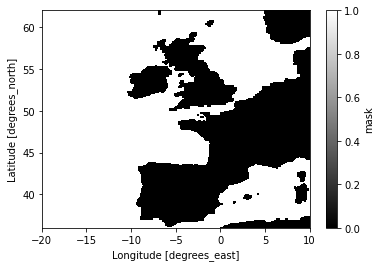

In [45]:
cnes_mdt.mask.plot(cmap="binary_r")

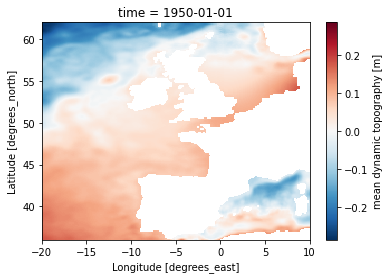

In [46]:
cnes_mdt.mdt.plot()

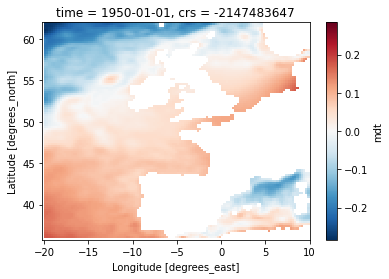

In [47]:
cnes_mdt4.mdt.plot()

In [48]:
# Save the dataset
cnes_mdt4.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/regridded/to aviso4/cnes_mdt.nc')

## Regrid the ROMS output NorthSea 1/4°

Now we have to regrid a curvilinear grid to a rectilinear grid 

In [62]:
roms_output_northsea4

<xarray.Dataset>
Dimensions:        (ocean_time: 21536, tracer: 2, boundary: 4, s_rho: 30,
                    s_w: 31, eta_rho: 110, xi_rho: 122, eta_u: 110, xi_u: 121,
                    eta_v: 109, xi_v: 122, eta_psi: 109, xi_psi: 121)
Coordinates:
  * s_rho          (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w            (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon            (eta_rho, xi_rho) float64 -19.88 -19.63 ... 9.631 9.877
    lat            (eta_rho, xi_rho) float64 35.95 35.95 35.95 ... 61.91 61.91
    lon_u          (eta_u, xi_u) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 1950-01-15 ... 2008-12-31
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/67)
    ntimes         (ocean_time) float64 1.261e+07 1.261e+07 ... 1.261e+07
    ndtfast        (ocean_time) float64 30.0 30.0 30.0 30.0 ... 30.0 30.0 30.0
    dt             (ocean_time) float64 150.0 150.0 150.0 ... 150.0 150.0 150.0
    dtfast         (ocean_time) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    dstart         (ocean_time) datetime64[ns] 1950-01-01 ... 1950-01-01
    nHIS           (ocean_time) float64 576.0 576.0 576.0 ... 576.0 576.0 576.0
    ...             ...
    angle          (eta_rho, xi_rho, ocean_time) float64 0.00126 ... 0.001893
    mask_rho       (eta_rho, xi_rho, ocean_time) float64 1.0 1.0 1.0 ... 0.0 0.0
    mask_u         (eta_u, xi_u, ocean_time) float64 1.0 1.0 1.0 ... 0.0 0.0 0.0
    mask_v         (eta_v, xi_v, ocean_time) float64 1.0 1.0 1.0 ... 0.0 0.0 0.0
    mask_psi       (eta_psi, xi_psi, ocean_time) float64 1.0 1.0 1.0 ... 0.0 0.0
    zeta           (ocean_time, eta_rho, xi_rho) float32 -0.2448 -0.2455 ... nan
Attributes: (12/33)
    file:              output/NorthSea4_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Extended North Sea, 0.25deg  Resolution
    var_info:          ../roms/ROMS/External/varinfo_2.yaml
    ...                ...
    compiler_command:  /sw/arch/Centos8/EB_production/2021/software/OpenMPI/4...
    compiler_flags:    -frepack-arrays -fallow-argument-mismatch  -fallow-arg...
    tiling:            006x004
    history:           ROMS/TOMS, Version 4.1, Monday - August 8, 2022 - 11:5...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       NORTH_SEA4, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, ATM...

In [49]:
# Add mask
roms_output_northsea4['mask'] = xr.where(~np.isnan(roms_output_northsea4.zeta.isel(ocean_time=0)), 1, 0)


# Rename coordinates
roms_output_northsea4 = roms_output_northsea4.rename({"lon_rho": "lon", "lat_rho": "lat"})

# Build regridder
regridder = xe.Regridder(roms_output_northsea4, aviso_altimetry4, "bilinear")


# Apply to data
roms_output_northsea4_rect = regridder(roms_output_northsea4)

/Users/iriskeizer/opt/anaconda3/envs/model2roms/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


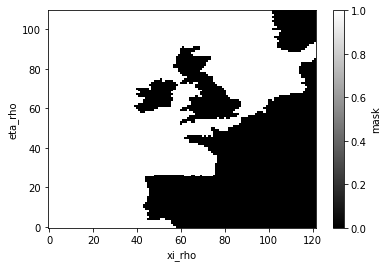

In [50]:
roms_output_northsea4.mask.plot(cmap="binary_r")

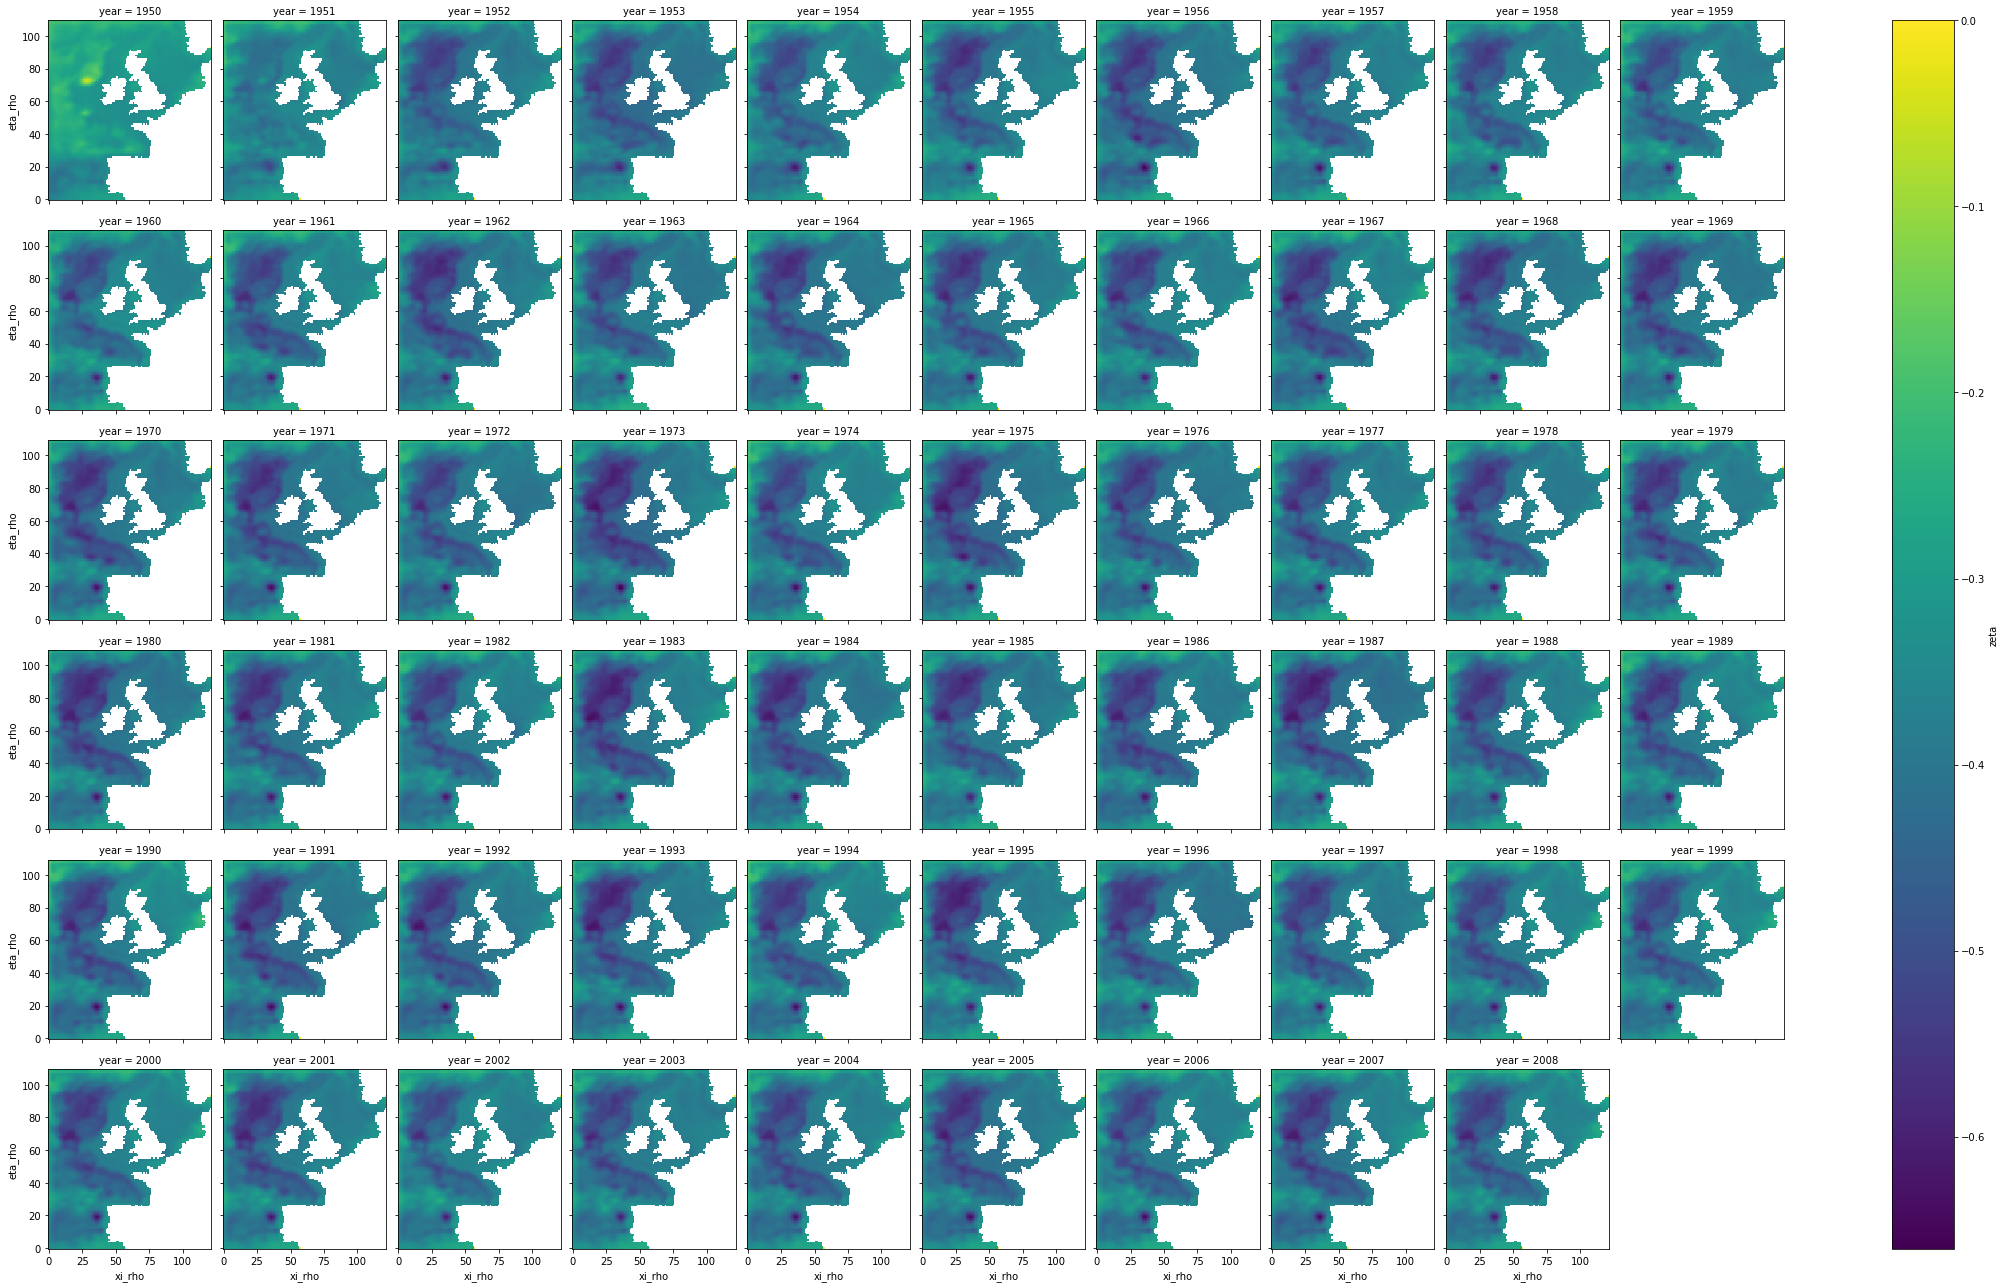

In [51]:
roms_output_northsea4_an = roms_output_northsea4.groupby('ocean_time.year').mean()

roms_output_northsea4_an.zeta.plot(col = 'year', col_wrap = 10)

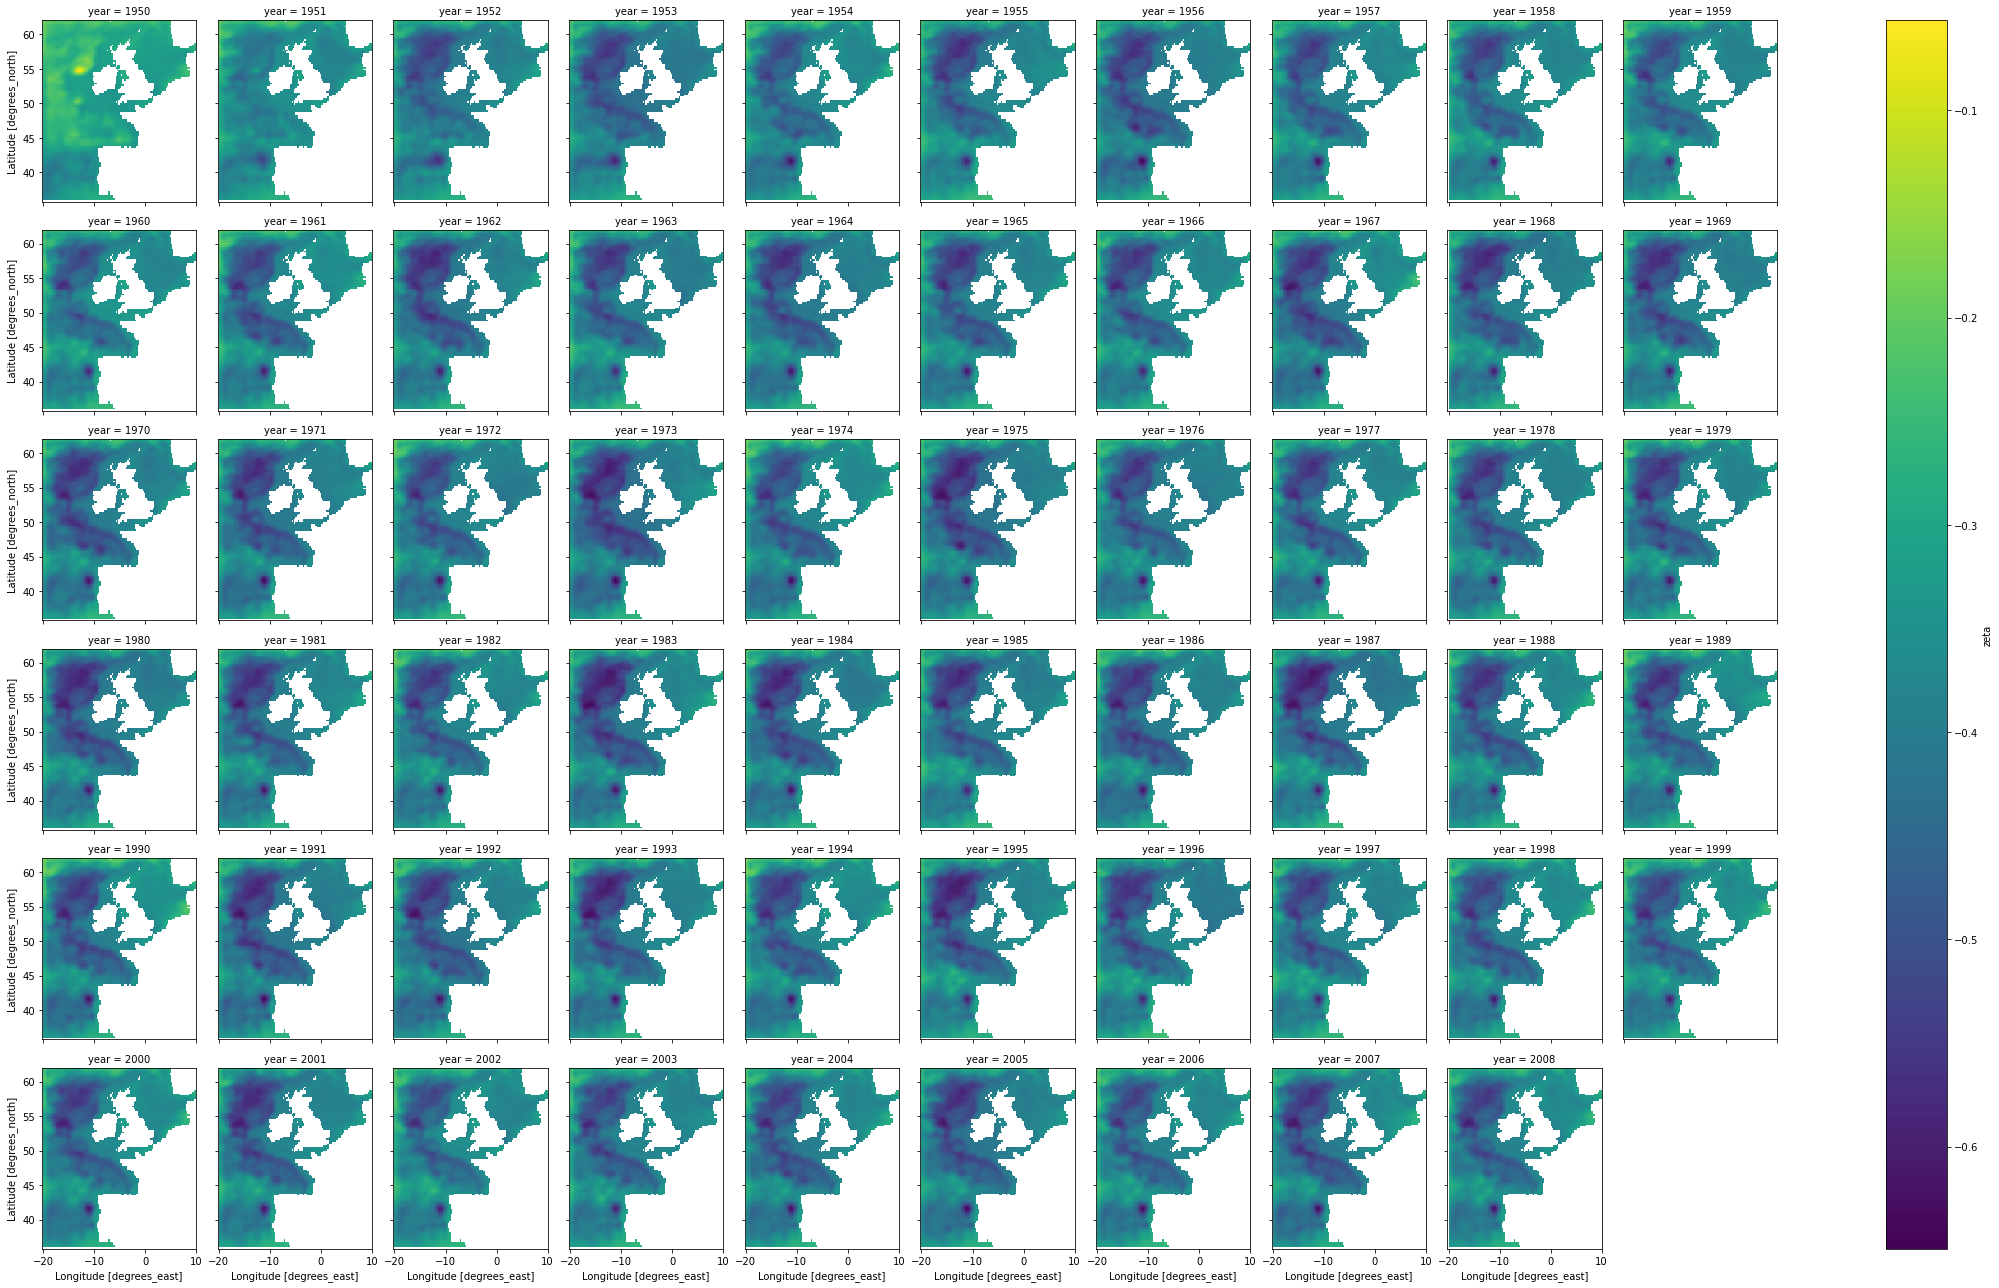

In [52]:
roms_output_northsea4_rect_an = roms_output_northsea4_rect.groupby('ocean_time.year').mean()

roms_output_northsea4_rect_an.zeta.plot(col = 'year', col_wrap = 10)

I'm super happy with these results!



In [53]:
# Save the dataset
roms_output_northsea4_rect.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/regridded/to aviso4/roms_output_northsea4.nc')

## Regrid the ROMS output NorthSea 1/8° from Tim

In [54]:
roms_output_tim_northsea8

<xarray.Dataset>
Dimensions:  (year: 26, lat: 218, lon: 242)
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017 2018
  * lat      (lat) float64 35.88 36.03 36.18 36.33 ... 61.69 61.78 61.87 61.96
  * lon      (lon) float64 -19.94 -19.81 -19.69 -19.57 ... 9.69 9.814 9.938
Data variables:
    slh      (year, lat, lon) float32 ...
Attributes:
    description:  ROMS slh output from Tim

In [55]:
# Add mask
roms_output_tim_northsea8['mask'] = xr.where(~np.isnan(roms_output_tim_northsea8.slh.isel(year=0)), 1, 0)
aviso_altimetry4['mask'] = xr.where(~np.isnan(aviso_altimetry4.adt.isel(time=0)), 1, 0)


# Build regridder
regridder = xe.Regridder(roms_output_tim_northsea8, aviso_altimetry4, "bilinear")


# Apply to data
roms_output_tim_northsea4 = regridder(roms_output_tim_northsea8)

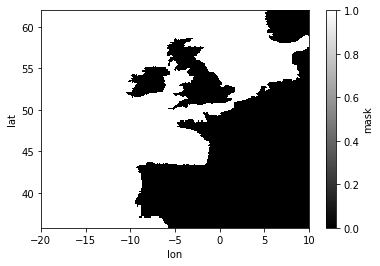

In [56]:
roms_output_tim_northsea8.mask.plot(cmap="binary_r")

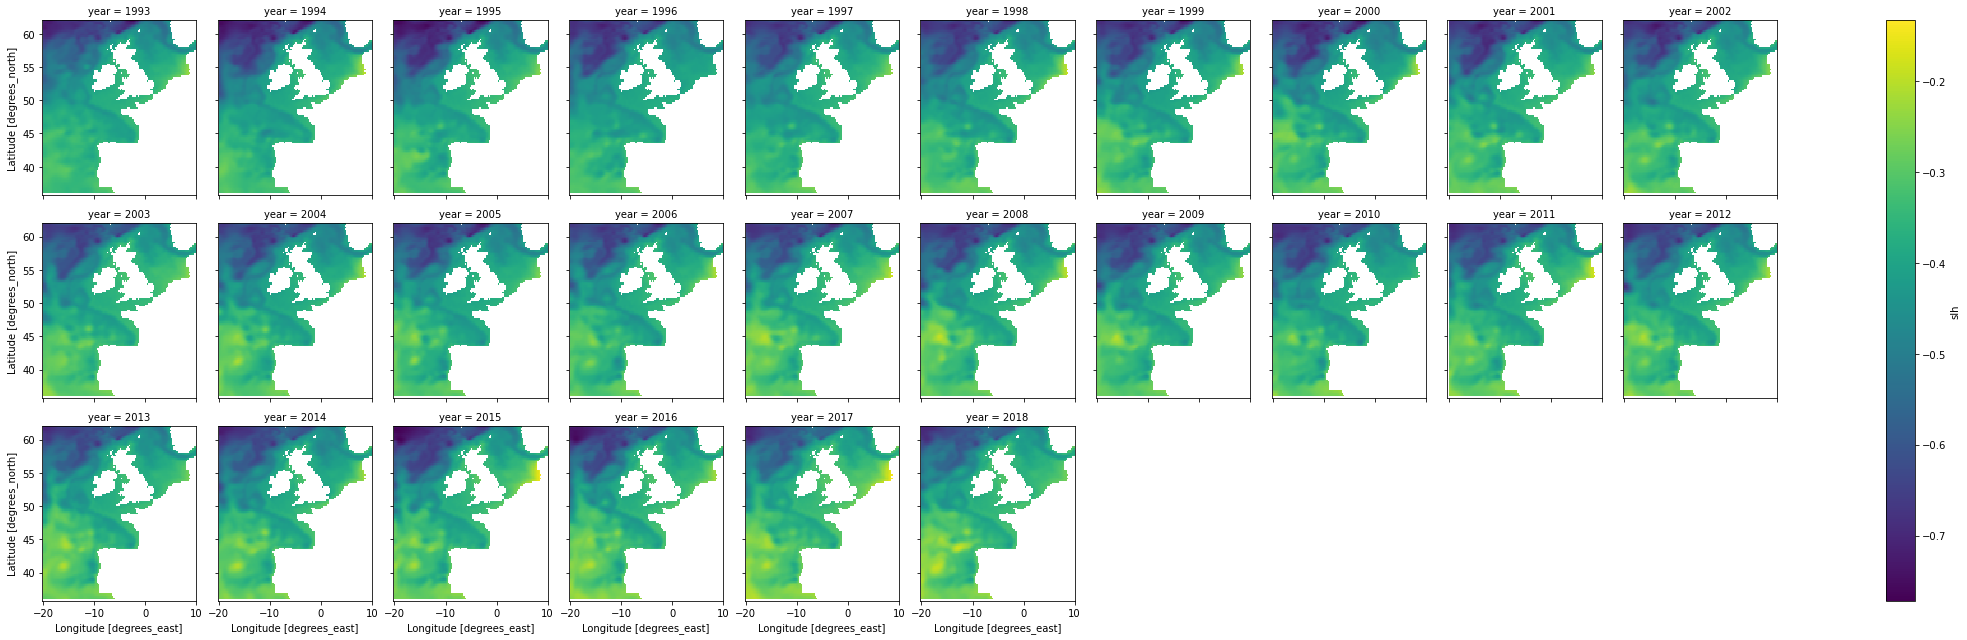

In [57]:
roms_output_tim_northsea4.slh.plot(col = 'year', col_wrap = 10)

In [58]:
# Save the dataset
roms_output_tim_northsea4.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/regridded/to aviso4/roms_output_tim_northsea8.nc')

## Regrid ROMS curvilinear to ROMS rectilinear

In [59]:
# Create output grid
ds_out = xr.Dataset(
    {
        "lat": (["lat"], roms_output_northsea4.lat.values[:,0]),
        "lon": (["lon"], roms_output_northsea4.lon.values[0]),
    }
)

# Remove mask
roms_output_northsea4 = roms_output_northsea4.drop('mask')


# Build regridder
regridder = xe.Regridder(roms_output_northsea4, ds_out, "bilinear")


# Apply to data
roms_output_northsea4_rect2 = regridder(roms_output_northsea4)

/Users/iriskeizer/opt/anaconda3/envs/model2roms/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


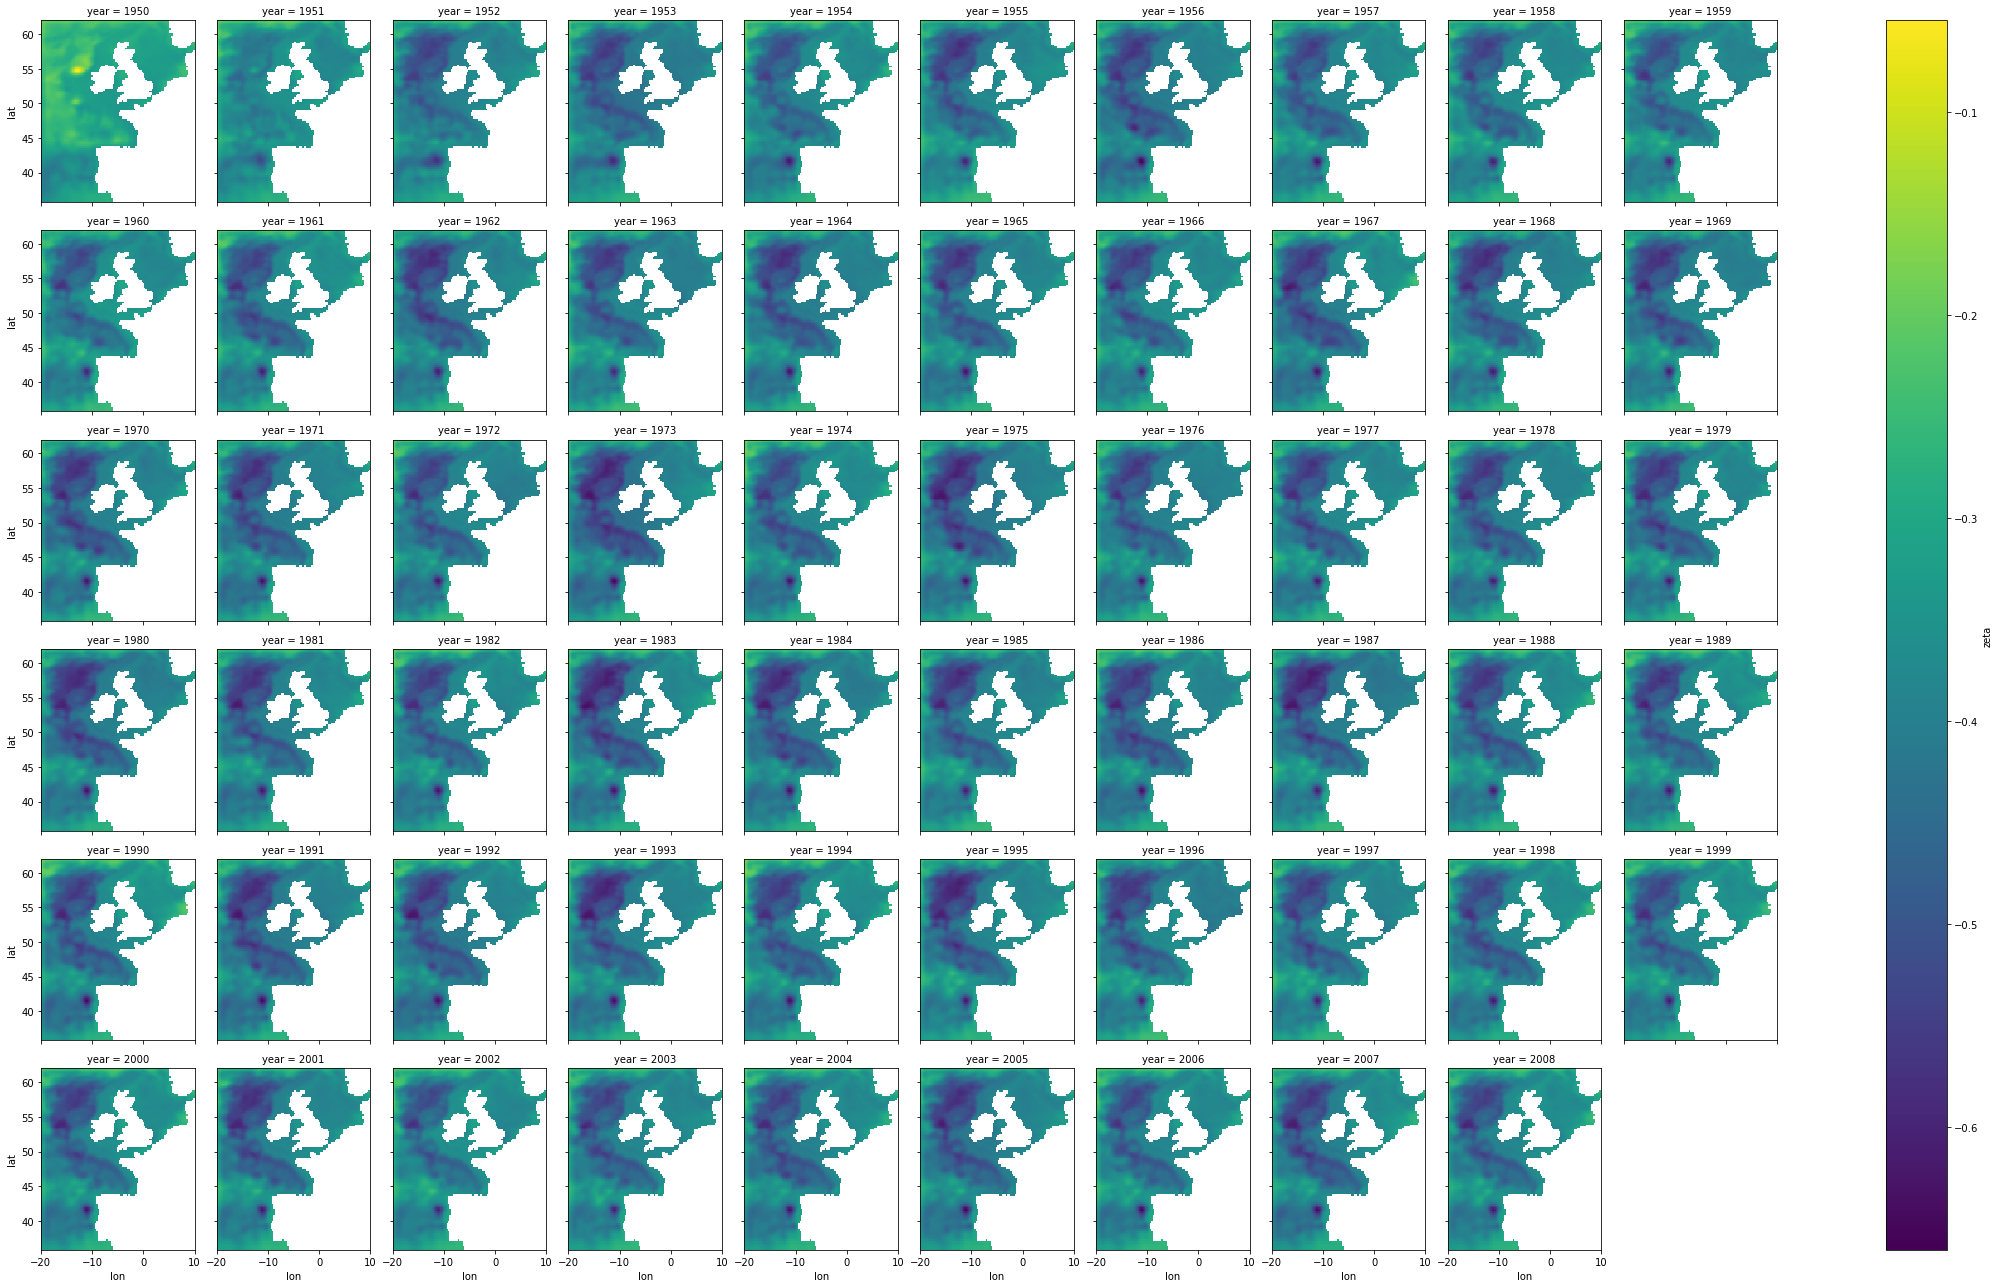

In [60]:
roms_output_northsea4_rect2_an = roms_output_northsea4_rect2.groupby('ocean_time.year').mean()

roms_output_northsea4_rect2_an.zeta.plot(col = 'year', col_wrap = 10)

In [61]:
# Save the dataset
roms_output_northsea4_rect2.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/regridded/to roms4 rect/roms_output_northsea4')